In [1]:
using Revise

In [2]:
using PyCall, PyPlot, Statistics

In [3]:
mpl = pyimport("matplotlib");
mpl.rcParams["lines.linewidth"] = 2;

In [4]:
using ClimateMARGO
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting
using ClimateMARGO.PolicyResponse
include("ebm.jl");

# Policy scenario: SRM termination in 2050

In [5]:
SRM = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));

In [6]:
max_deployment = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>1., "adapt"=>0.);
max_deployment_noSRM = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>0., "adapt"=>0.);

In [7]:
optimize_controls!(SRM, obj_option="net_benefit", max_deployment=max_deployment);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded


In [8]:
only_SRM = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));
max_deployment_only_SRM = Dict("mitigate"=>0., "remove"=>0., "geoeng"=>1., "adapt"=>0.);
optimize_controls!(only_SRM, obj_option="net_benefit", max_deployment=max_deployment_only_SRM);
only_SRM_term = deepcopy(only_SRM)
step_forward!(only_SRM_term, 40.)
only_SRM_term.controls.geoeng[t(only_SRM_term) .> only_SRM_term.domain.present_year] .= 0.;

Solve_Succeeded


In [9]:
noSRM = deepcopy(SRM)
optimize_controls!(
    noSRM, obj_option="net_benefit",
    max_deployment=max_deployment_noSRM
);

Solve_Succeeded


In [10]:
SRM_term = deepcopy(SRM)
step_forward!(SRM_term, 40.)
terminate_year = Int(SRM_term.domain.present_year)
SRM_term_response = deepcopy(SRM_term);

In [11]:
SRM_term.controls.geoeng[t(SRM_term) .> 2060] .= 0.;
SRM_term.domain.present_year = 2020.;

In [12]:
max_slope = Dict("mitigate"=>1. /40., "remove"=>1. /40., "geoeng"=>Inf, "adapt"=> 0.)
optimize_controls!(
    SRM_term_response, obj_option="net_benefit",
    max_deployment=max_deployment_noSRM, max_slope=max_slope
);
SRM_term_response.domain.present_year = 2020.;

Solve_Succeeded


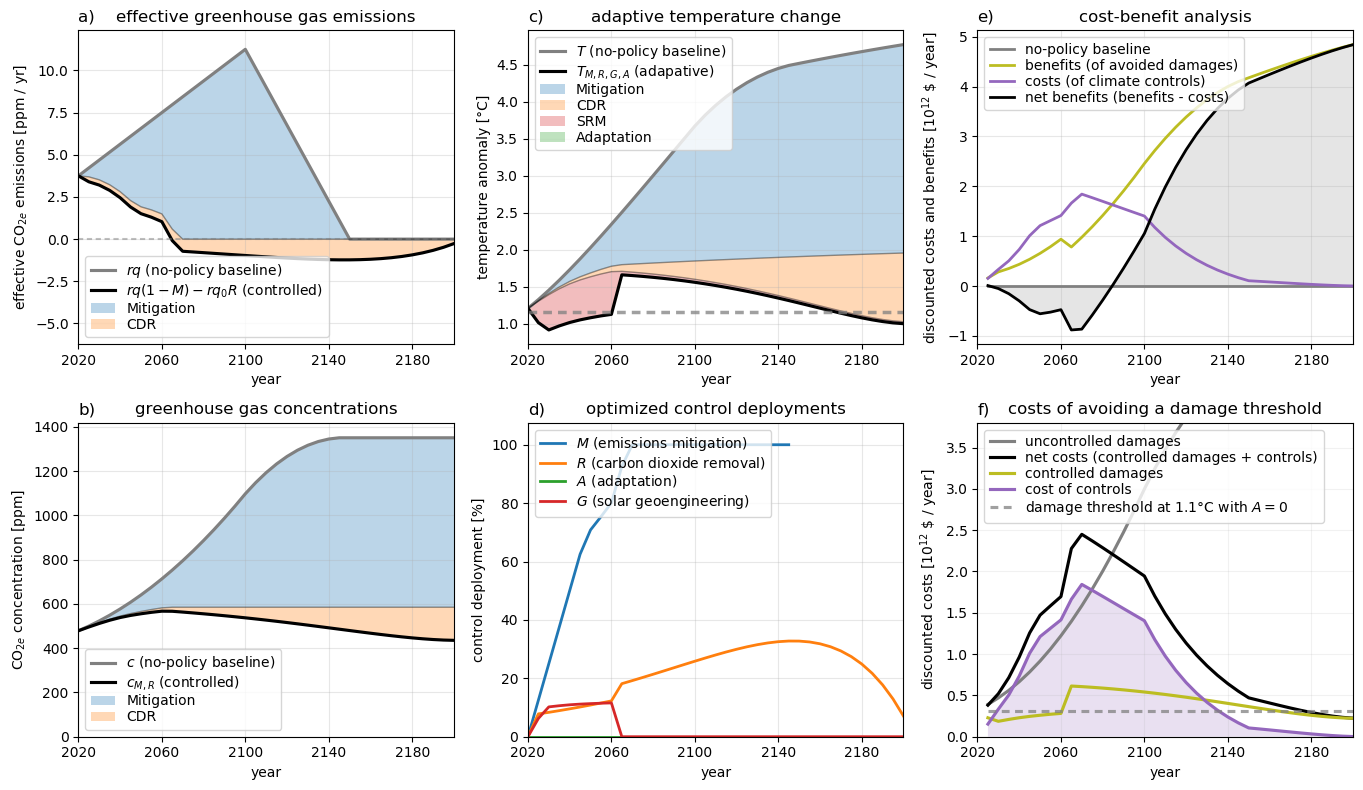

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff174f58b70>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff159bf6c50>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff1736a30f0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff15aae5240>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff159b4d6a0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff15ae3d7f0>])

In [13]:
plot_state(SRM_term_response)

In [14]:
using Interpolations

## SRM_term
F_lo = F(SRM_term, M=true, R=true, G=true);
t_lo = t(SRM_term)

Δt = 0.1
t_hi = 2020.:Δt:2200.

itp = interpolate((t_lo,), F_lo, Gridded(Linear()))
F_hi = itp(t_hi);

itp = interpolate((t_lo,), SRM_term.controls.adapt, Gridded(Linear()))
A_hi = itp(t_hi);

T_hi = DICE_EBM(t_hi, Δt, F_hi, default="Geoffroy-2013") .+ SRM_term.physics.T0;

## only_SRM_term
F_lo_only = F(only_SRM_term, M=true, R=true, G=true);
t_lo_only = t(only_SRM_term)

Δt = 0.1
t_hi_only = 2020.:Δt:2200.

itp = interpolate((t_lo_only,), F_lo_only, Gridded(Linear()))
F_hi_only = itp(t_hi_only);

itp = interpolate((t_lo_only,), only_SRM_term.controls.adapt, Gridded(Linear()))
A_hi_only = itp(t_hi_only);

T_hi_only = DICE_EBM(t_hi_only, Δt, F_hi_only, default="Geoffroy-2013") .+ only_SRM_term.physics.T0;

### Plots and calculations

In [15]:
using PyCall
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);

##### Modified damage functions

In [16]:
damage(β, E, Ta, T, c, dt; discount=1., βCO2=0., βdTdt=0.) = (
    (β .* E .* Ta.^2) .+
    (βCO2 .* E .* (c.-280.)) .+
    insert!(βdTdt .* (E[1:end-1] .+ E[2:end])/2. .* (diff(T)./dt).^2, 1, 0.) 
) .* discount

damage(m; discounting=false, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = damage(
    m.economics.β,
    E(m),
    T_adapt(m, M=M, R=R, G=G, A=A),
    T(m, M=M, R=R, G=G),
    c(m, M=M, R=R),
    m.domain.dt,
    discount=1. .+ discounting * (discount(m) .- 1.),
    βCO2=βCO2,
    βdTdt=βdTdt
)

benefit(damage_baseline, damage) = damage_baseline .- damage
benefit(m::ClimateModel; discounting=false, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = benefit(
    damage(m, discounting=discounting, βCO2=βCO2, βdTdt=βdTdt),
    damage(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt)
)

net_benefit(benefit, cost) = benefit .- cost
net_benefit(m::ClimateModel; discounting=true, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = net_benefit(
    benefit(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt),
    cost(m, discounting=discounting, M=M, R=R, G=G, A=A)
)

net_present_benefit_mod(net_benefit, dt) = sum(net_benefit*dt)
net_present_benefit_mod(m::ClimateModel; discounting=true, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = net_present_benefit_mod(
    net_benefit(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt),
    m.domain.dt
)

net_present_benefit_mod (generic function with 2 methods)

In [17]:
fig1 = figure(figsize=(10.75, 6))
gs = fig1.add_gridspec(7, 6)

##
ax1 = fig1.add_subplot(get(gs, (slice(0,4), slice(0,3))))

ax2 = fig1.add_subplot(get(gs,(slice(4,7), slice(0,2))))
ax2.set_ylim(0, 110)
ax2.set_yticks([0, 25, 50, 75, 100])

ax3 = fig1.add_subplot(get(gs,(slice(4,7), slice(2,4))))
ax3.set_ylim(0, 35)
ax3.set_yticks([0, 10, 20, 30])

ax4 = fig1.add_subplot(get(gs,(slice(4,7), slice(4,6))))
ax4.set_ylim(0, 15)
ax4.set_yticks([0, 5, 10])

# ax5 = fig1.add_subplot(get(gs,(slice(4,7), slice(6,8))))
# ax5.set_ylim(0, 25)
# ax5.set_yticks([0, 5, 10, 15, 20, 25])

ax6 = fig1.add_subplot(get(gs, (slice(0,4), slice(3,6))))

for ax in [ax1, ax2, ax3, ax4, ax5]
    ax.grid(true, alpha=0.2)
    ax.set_xlim(2020., 2200.)
    ax.set_xlabel("year")
end

ax2.set_xlim(2020., 2150)

for ax in [ax2, ax3, ax4, ax5]
    ax.set_ylabel("deployment [%]")
end

ax1.plot(t(SRM),T(SRM), "-", color="grey", label="no-policy baseline", lw=3, alpha=0.9)
m = noSRM
ax1.plot(t(m),T_adapt(m, M=true, R=true, G=true, A=true), color="k", ls="--", lw=2, alpha=0.75)
m = SRM
ax1.plot(t(m),T_adapt(m, M=true, R=true, G=true, A=true), color="k", alpha=0.75, ls=":", lw=2)
m = SRM_term_response
ax1.plot(t(m),T_adapt(m, M=true, R=true, G=true, A=true), color="k", lw=3, ls="-")
m = SRM_term
ax1.plot(t_hi, T_hi, color="k", lw=1.5, ls=(0, (3,1,1,1)), alpha=0.2)
ax1.plot(t(m),T_adapt(m, M=true, R=true, G=true, A=true), color="k", lw=3, alpha=0.75, ls=(0, (3,1,1,1)))

ax1.plot([],[], lw=2, ls="--", color="k", label="SRM never allowed (No-SRM)")
ax1.plot([],[], lw=2, ls=":", color="k", label="SRM always allowed (Yes-SRM)")
ax1.plot([],[], lw=2, alpha=0.75, ls=(0, (3,1,1,1)), color="k", label="SRM terminated in $(terminate_year) (Term-SRM)")
ax1.plot([],[], lw=3, ls="-", color="k", label="Termination & response (Term-Response)")

ax1.legend(loc="upper right", labelspacing=0.225, framealpha=0.95)
ax1.set_ylim([0.75, 2.5])
ax1.set_ylabel("warming, relative to pre-industrial [°C]")
ax1.set_title("a) Controlled temperature change in SRM scenarios", loc="left", fontsize=11.5)

arrowprops=Dict(
    "arrowstyle"=>"<|-|>",
    "fc"=>"C3", "ec"=>"C3"
)
ax1.annotate("", (2068, 1.13), xytext=(2068, 1.67), arrowprops=arrowprops)
ax1.annotate("termination\nshock", (2065, 0.90), fontsize=12, color="C3");

ax1.annotate("", (2130, 1.292), xytext=(2130, 1.582), arrowprops=arrowprops)
ax1.annotate("moral\nhazard", (2120.1, 1.615), fontsize=12, color="C3");

## 
m = noSRM
qidx = (m.economics.baseline_emissions .> 0)
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls="--", lw=1.5, alpha=0.6)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls="--", lw=2, alpha=0.6)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls="--", lw=2, alpha=0.6)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls="--", lw=2, alpha=0.6)

m = SRM
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls=":", lw=2, alpha=0.6)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls=":", lw=2, alpha=0.6)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls=":", lw=2, alpha=0.6)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls=":", lw=2, alpha=0.6)

m = SRM_term_response
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls="-", lw=2.5)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls="-", lw=2.5)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls="-", lw=2.5)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls="-", lw=2.5)

ax2.set_title(L"c) Emissions $\mathbf{M}$itigation", fontsize=10.5, loc="left")
ax3.set_title(L"d) Carbon Dioxide $\mathbf{R}$emoval", fontsize=10.5, loc="left")
ax4.set_title(L"e) Solar $\mathbf{G}$eoengineering", fontsize=10.5, loc="left")
ax5.set_title(L"f) $\mathbf{A}$daptation", fontsize=9.5, loc="left")

##
m = noSRM
ax6.plot(t(SRM), c(SRM), "-", color="grey", lw=3, alpha=0.8)
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls="--", lw=2)
m = SRM
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls=":", lw=2)
m = SRM_term_response
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls="-", lw=3)

ax6.annotate("", (2090, 522), xytext=(2090, 571), arrowprops=arrowprops)
ax6.annotate("moral\nhazard", (2080, 580.2), fontsize=12, color="C3");

ax6.set_ylim(420, 700)
grid(true, alpha=0.2)
ax6.set_xlim(2020., 2200.)
ax6.set_xlabel("year")
ax6.set_ylabel(L"CO$_{2e}$ concentration [ppm]")
ax6.set_title(L"b) Controlled CO$_{2e}$ concentrations in SRM scenarios", loc="left", fontsize=11.5)

fig1.tight_layout(w_pad=0.075, h_pad=0.10)
fig1.savefig("figures/scenario-B_SRM_termination.png", dpi=200., bbox_inches="tight")

fig2 = figure(figsize=(6.25,3.75))

##
plot(t(SRM),T_adapt(SRM), "-", color="grey", label="no-policy baseline", lw=3, alpha=0.9)
m = only_SRM
plot(t(m),T_adapt(m, M=true, R=true, G=true, A=true), lw=2.25, ls=":", color="C4", label="SRM-only")
m = only_SRM_term
plot(t_hi_only, T_hi_only, color="C4", lw=1.5, ls="-", alpha=0.2)
plot(t(m), T_adapt(m, M=true, R=true, G=true, A=true), lw=2.25, ls="-", color="C4", label="SRM-only, terminated in 2060")
ylim(0.5, 5.0)
legend(loc="lower right", labelspacing=0.14)
ylabel("warming, relative to pre-industrial [°C]")
title("Controlled temperature change in SRM-only scenarios", loc="left", fontsize=11.5)
grid(true, alpha=0.2)
xlim(2020., 2200.)
xlabel("year")

fig2.savefig("figures/supp_scenario-B_SRM-only_termination.png", dpi=200., bbox_inches="tight")


LoadError: UndefVarError: ax5 not defined

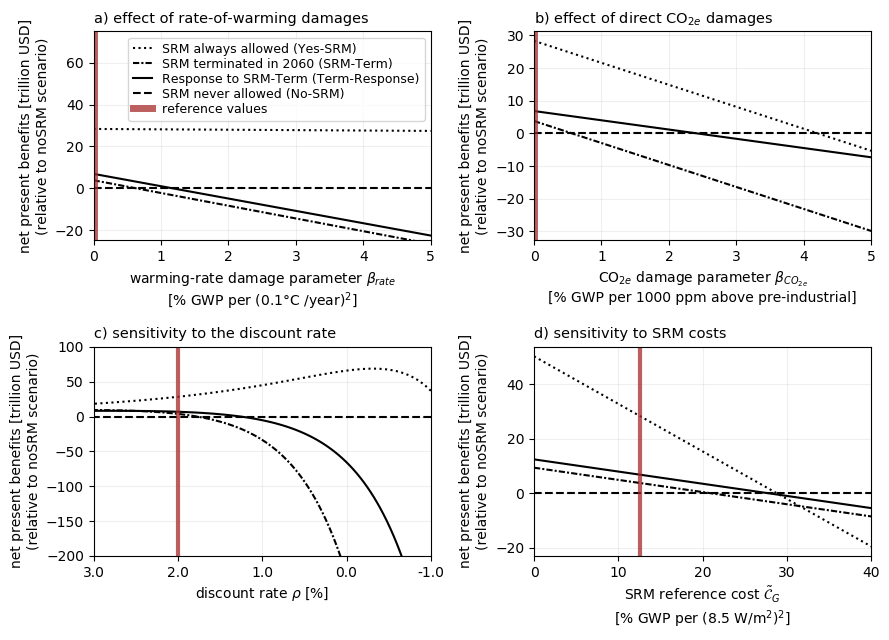

In [18]:
fig2 = figure(figsize=(9, 6.5))
ax4 = fig2.add_subplot(2,2,1)
ax5 = fig2.add_subplot(2,2,2)
#ax3 = fig2.add_subplot(2,2,3)
ax1 = fig2.add_subplot(2,2,3)
ax2 = fig2.add_subplot(2,2,4)

##
ρmax = 0.03
ρmin = -0.01
ρs = -0.01:(ρmax-ρmin)/100.:ρmax;

function NPB(m, ρ)
    tmp = deepcopy(m)
    tmp.economics.ρ = ρ
    return net_present_benefit(tmp, M=true, R=true, G=true, A=true)
end

NPB_mod_SRM_term_response = [NPB(SRM_term_response, ρ) for ρ in ρs]
NPB_mod_SRM_term = [NPB(SRM_term, ρ) for ρ in ρs]
NPB_mod_noSRM = [NPB(noSRM, ρ) for ρ in ρs]
NPB_mod_SRM = [NPB(SRM, ρ) for ρ in ρs]

ax1.grid(true, alpha=0.2)
ax1.plot(ρs, NPB_mod_noSRM-NPB_mod_noSRM, "k--")
ax1.plot(ρs, NPB_mod_SRM-NPB_mod_noSRM, "k:")
ax1.plot(ρs, NPB_mod_SRM_term-NPB_mod_noSRM, "k", ls=(0, (3,1,1,1)))
ax1.plot(ρs, NPB_mod_SRM_term_response-NPB_mod_noSRM, "k-")
ax1.axvline(SRM.economics.ρ, color="brown", linestyle="-", lw=3, alpha=0.75)
ax1.set_xlim(ρs[end], ρs[1])
ax1.set_ylim(-200, 100)
yl = ax1.get_ylim()
xt = ρs[1]:(ρmax-ρmin)/4:ρs[end]
ax1.set_xticks(xt)
ax1.set_xticklabels(round.(xt*100, digits=1))

# _, i1 = findmin(abs.(NPB_mod_SRM .- NPB_mod_noSRM))
# ax1.fill_between([ρs[1], ρs[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.12, color="C0")

# _, i2 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
# ax1.fill_between([ρs[i1], ρs[i2]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.12)
# ax1.fill_between([ρs[i2], ρs[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.3)

ax1.set_ylim(yl)
ax1.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax1.set_xlabel(L"discount rate $\rho$ [%]")
ax1.set_title("c) sensitivity to the discount rate", loc="left", fontsize=10.5)

##
CGmax = 0.40
CGs = 0:CGmax/50.:CGmax;

function NPB_CG(m, CG)
    tmp = deepcopy(m)
    tmp.economics.geoeng_cost = CG
    return net_present_benefit(tmp, M=true, R=true, G=true, A=true)
end

NPB_mod_SRM_term_response = [NPB_CG(SRM_term_response, CG) for CG in CGs]
NPB_mod_SRM_term = [NPB_CG(SRM_term, CG) for CG in CGs]
NPB_mod_noSRM = [NPB_CG(noSRM, CG) for CG in CGs]
NPB_mod_SRM = [NPB_CG(SRM, CG) for CG in CGs]

ax2.grid(true, alpha=0.2)
ax2.plot(CGs, NPB_mod_noSRM-NPB_mod_noSRM, "k--")
ax2.plot(CGs, NPB_mod_SRM-NPB_mod_noSRM, "k:")
ax2.plot(CGs, NPB_mod_SRM_term-NPB_mod_noSRM, "k", ls=(0, (3,1,1,1)))
ax2.plot(CGs, NPB_mod_SRM_term_response-NPB_mod_noSRM, "k-")
ax2.axvline(SRM.economics.geoeng_cost, color="brown", linestyle="-", lw=3, alpha=0.75)
ax2.set_xlim(CGs[1], CGs[end])
yl = ax2.get_ylim()
xt = CGs[1]:CGs[end]/4:CGs[end]
ax2.set_xticks(xt)
ax2.set_xticklabels(Int.(round.(xt*100, digits=1)))

# _, i1 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_SRM))
# ax2.fill_between([CGs[1], CGs[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.3, color="C3")

# _, i2 = findmin(abs.(NPB_mod_SRM .- NPB_mod_noSRM))
# ax2.fill_between([CGs[i1], CGs[i2]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.3, color="C1")

# _, i3 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
# ax2.fill_between([CGs[i2], CGs[i3]], [yl[1], yl[1]], [yl[2], yl[2]], color="C1", alpha=0.12)
# ax2.fill_between([CGs[i3], CGs[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C0", alpha=0.3)

ax2.set_ylim(yl)
ax2.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax2.set_xlabel(string(
    L"SRM reference cost $\tilde{\mathcal{C}}_{G}$",
    "\n",
    L"[% GWP per (8.5 W/m$^{2}$)$^{2}$]"
))
ax2.set_title("d) sensitivity to SRM costs", loc="left", fontsize=10.5)

# ax2.fill_between([], [], [], color="C3", alpha=0.3, label="SRM > Term > NoSRM")
# ax2.fill_between([], [], [], color="C3", alpha=0.12, label="SRM  > NoSRM > Term")
# ax2.fill_between([], [], [], color="C1", alpha=0.3, label="Term > SRM > NoSRM")
# ax2.fill_between([], [], [], color="C1", alpha=0.12, label="Term > NoSRM > SRM")
# ax2.fill_between([], [], [], color="C0", alpha=0.12, label="NoSRM > SRM > Term")
# ax2.fill_between([], [], [], color="C0", alpha=0.3, label="NoSRM > Term > SRM")
# ax2.legend(labelspacing=0.2, handlelength=0.5, fontsize=9, loc="upper right")

##
βdTdtmax = (5. /100.) / ((1. /10.)^2) # 10% GWP damages for (1ºC warming in 10 years)^2
βdTdts = 0.:βdTdtmax/50.:βdTdtmax;

NPB_mod_SRM_term_response = [net_present_benefit_mod(SRM_term_response, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]
NPB_mod_SRM_term = [net_present_benefit_mod(SRM_term, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]
NPB_mod_noSRM = [net_present_benefit_mod(noSRM, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]
NPB_mod_SRM = [net_present_benefit_mod(SRM, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]

ax4.grid(true, alpha=0.2)
ax4.plot(βdTdts, NPB_mod_SRM-NPB_mod_noSRM, "k:", label="SRM always allowed (Yes-SRM)")
ax4.plot(βdTdts, NPB_mod_SRM_term-NPB_mod_noSRM, "k", ls=(0,(3,1,1,1)), label="SRM terminated in $(terminate_year) (SRM-Term)")
ax4.plot(βdTdts, NPB_mod_SRM_term_response-NPB_mod_noSRM, "k-", label="Response to SRM-Term (Term-Response)")
ax4.plot(βdTdts, NPB_mod_noSRM-NPB_mod_noSRM, "k--", label="SRM never allowed (No-SRM)")
ax4.axvline(0., color="brown", linestyle="-", lw=5, alpha=0.75, label="reference values")
ax4.set_ylim(-25, 75)
ax4.set_xlim(βdTdts[1], βdTdts[end])
yl = ax4.get_ylim()
xt = βdTdts[1]:βdTdts[end]/5:βdTdts[end]
ax4.set_xticks(xt)
ax4.set_xticklabels(Int.(round.(xt*100*((1/10.)^2), digits=1)))

ax4.set_ylim(yl)
ax4.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax4.set_xlabel(string(
    L"warming-rate damage parameter $\beta_{rate}$",
    "\n",
    L"[% GWP per (0.1°C /year)$^{2}$]"
))
ax4.set_title("a) effect of rate-of-warming damages", loc="left", fontsize=10.5)
ax4.legend(labelspacing=0.16, handlelength=1.5, fontsize=9, loc="upper right")

##
βCO2max = (5. /100.) / 1000. # 5% GWP damages for 1000 ppm increase in CO2
βCO2s = 0.:βCO2max/50.:βCO2max;

NPB_mod_SRM_term_response = [net_present_benefit_mod(SRM_term_response, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]
NPB_mod_SRM_term = [net_present_benefit_mod(SRM_term, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]
NPB_mod_noSRM = [net_present_benefit_mod(noSRM, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]
NPB_mod_SRM = [net_present_benefit_mod(SRM, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]

ax5.grid(true, alpha=0.2)
ax5.plot(βCO2s, NPB_mod_SRM_term_response-NPB_mod_noSRM, "k-")
ax5.plot(βCO2s, NPB_mod_SRM_term-NPB_mod_noSRM, "k", ls=(0,(3,1,1,1)))
ax5.plot(βCO2s, NPB_mod_noSRM-NPB_mod_noSRM, "k--")
ax5.plot(βCO2s, NPB_mod_SRM-NPB_mod_noSRM, "k:")
ax5.axvline(0., color="brown", linestyle="-", lw=5, alpha=0.75)
ax5.set_xlim(βCO2s[1], βCO2s[end])
yl = ax5.get_ylim()
xt = βCO2s[1]:βCO2s[end]/5:βCO2s[end]
ax5.set_xticks(xt)
ax5.set_xticklabels(Int.(xt*100*1000))

# _, i1 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
# ax5.fill_between([0, βCO2s[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.3, color="C3", label="SRM > Term > NoSRM")

# _, i2 = findmin(abs.(NPB_mod_SRM .- NPB_mod_noSRM))
# ax5.fill_between([βCO2s[i1], βCO2s[i2]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.12, label="SRM  > NoSRM > Term")

# _, i3 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_SRM))
# ax5.fill_between([βCO2s[i2], βCO2s[i3]], [yl[1], yl[1]], [yl[2], yl[2]], color="C0", alpha=0.12, label="NoSRM > SRM > Term")

# _, i4 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_SRM))
# ax5.fill_between([βCO2s[i3], βCO2s[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C0", alpha=0.3, label="NoSRM > Term > SRM")

ax5.set_ylim(yl)
ax5.set_ylabel("net present benefits [trillion USD]\n(relative to noSRM scenario)")
ax5.set_xlabel(string(
    L"CO$_{2e}$ damage parameter $\beta_{CO_{2e}}$",
    "\n[% GWP per 1000 ppm above pre-industrial]"
))
ax5.set_title(L"b) effect of direct CO$_{2e}$ damages", loc="left", fontsize=10.5)

fig2.tight_layout()
fig2.savefig("figures/SRM_termination_sensitivity.png", dpi=200., bbox_inches="tight")

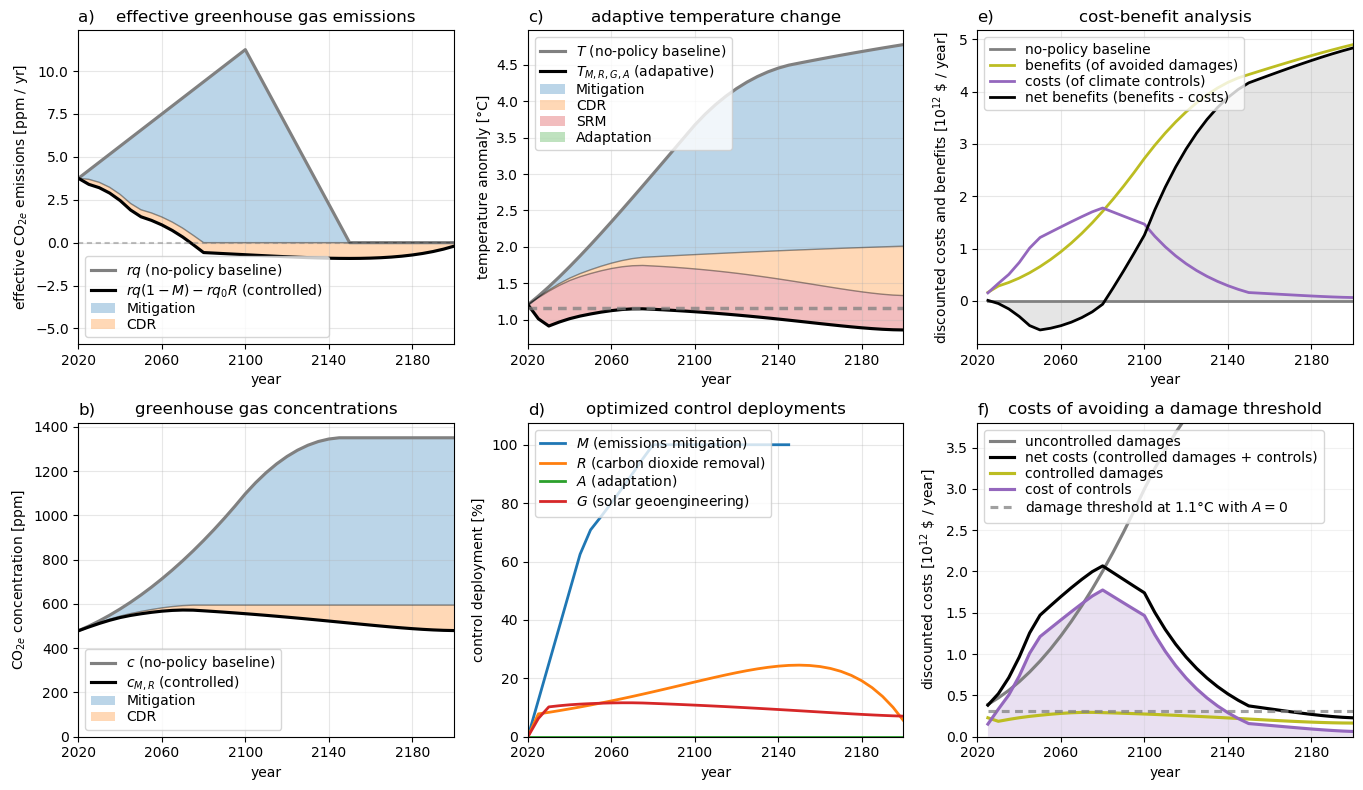

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf1715fa90>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf17d8c588>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf17d2f668>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf17dc6b38>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf171def98>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf17dfe128>])

In [20]:
plot_state(SRM)

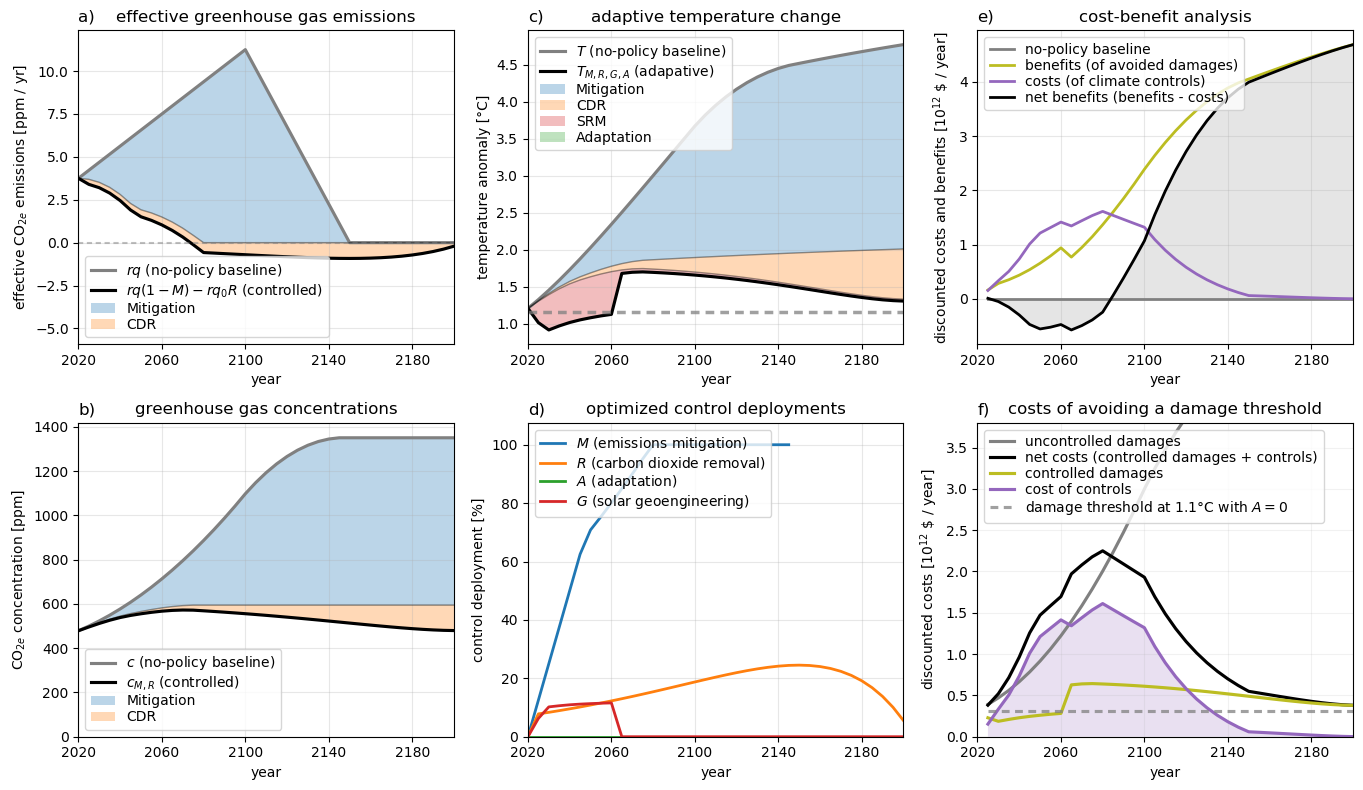

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf19621e48>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf17dafeb8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf195fa128>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf195f64a8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf19188b38>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf1964fa58>])

In [21]:
plot_state(SRM_term)

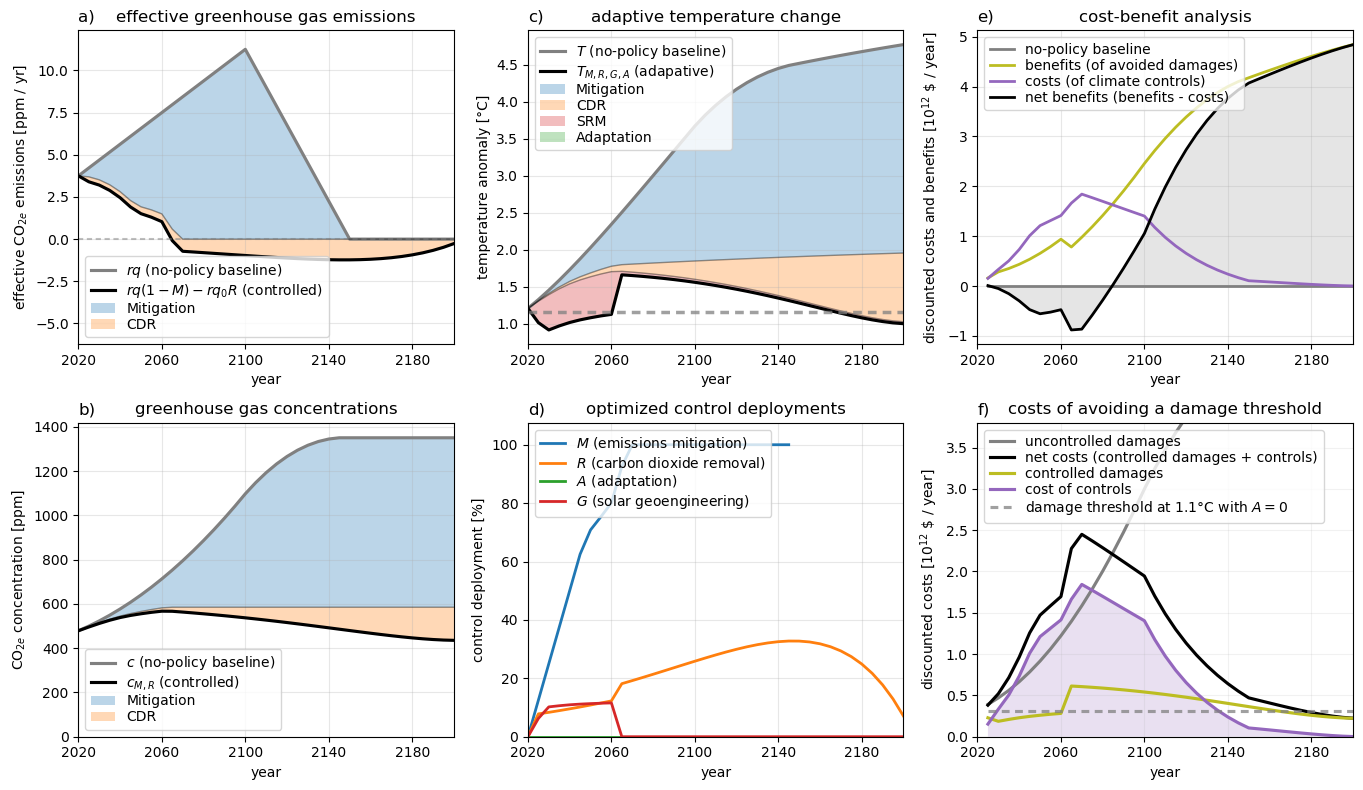

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf19d96438>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf1a401208>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf1a2394e0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf1a4287b8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf1a247c18>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf1a4d5d68>])

In [22]:
plot_state(SRM_term_response)

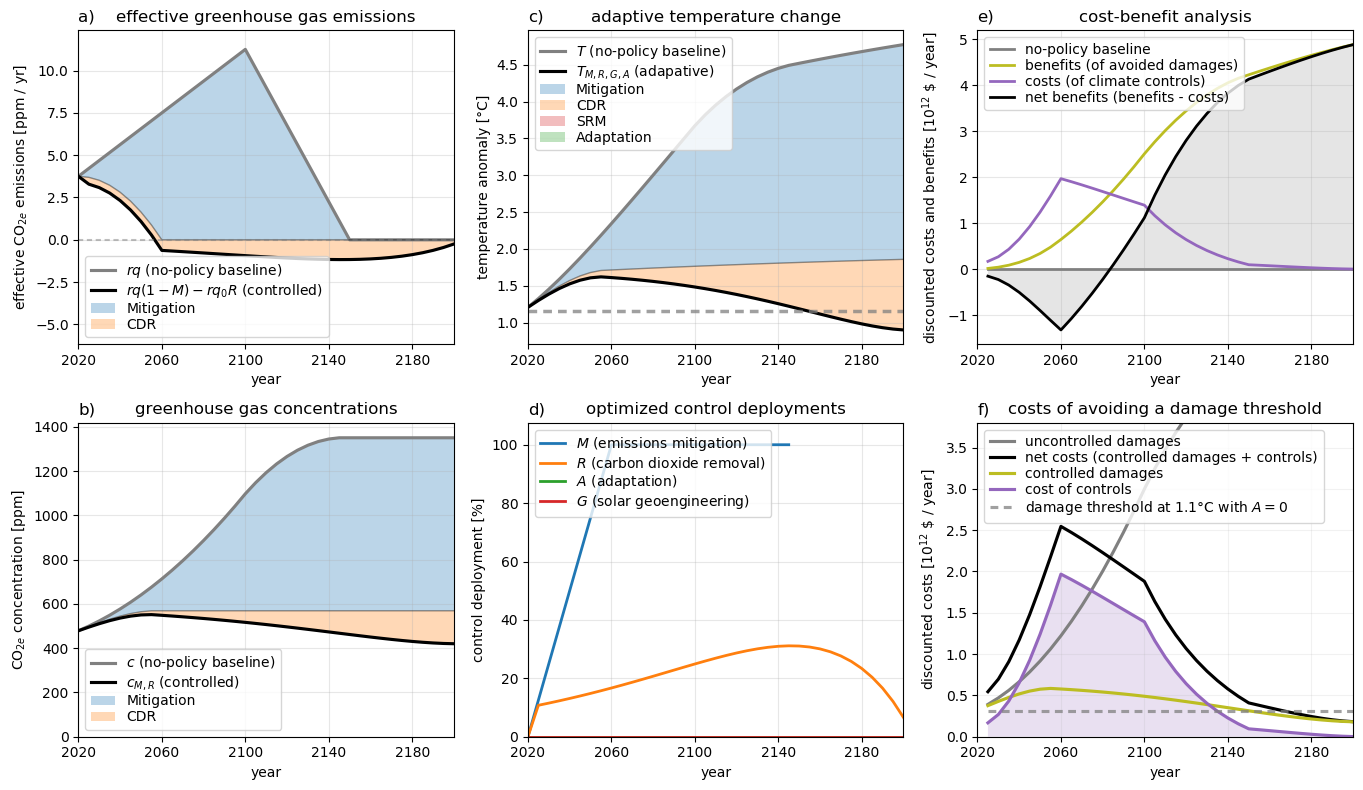

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf1750ac18>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf175af6d8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf17463f60>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf175dac88>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf1751a128>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf17692278>])

In [23]:
plot_state(noSRM)

# Sensitivity to timestep

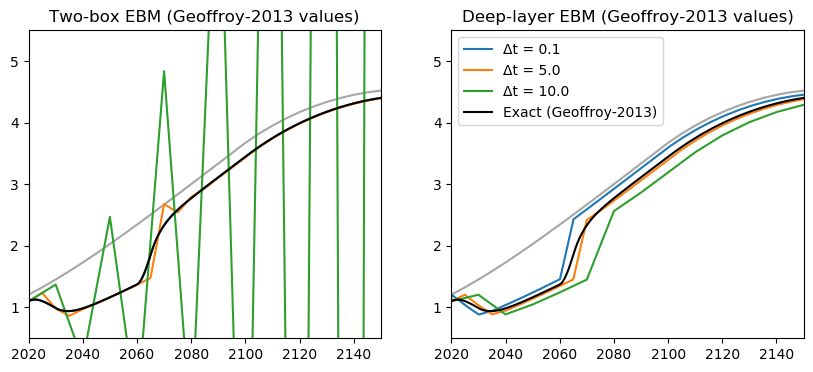

PyObject <matplotlib.legend.Legend object at 0x7ff15ffff0b8>

In [20]:
using Interpolations

## SRM_term
F_lo = F(only_SRM_term, M=true, R=true, G=true);
t_lo = t(only_SRM_term)

figure(figsize=(10, 4))

for i = [1,2]
    subplot(1,2,i)
    plot(t(SRM), T(SRM), "k-", color="grey", alpha=0.7)
end

for Δt = [0.1, 5.0, 10.]
    t_hi = 2020.:Δt:2200.

    itp = interpolate((t_lo,), F_lo, Gridded(Linear()))
    F_hi = itp(t_hi);
    
    subplot(1,2,1)
    T_hi = DICE_EBM(t_hi, Δt, F_hi, default="Geoffroy-2013") .+ SRM_term.physics.T0;
    plot(t_hi, T_hi, label=string("δt = ",Δt))
    ylim(0.5, 5.5)
    xlim(2020, 2150)
    title("Two-box EBM (Geoffroy-2013 values)")
    
    subplot(1,2,2)
    T_hi = DICE_EBM(t_hi, Δt, F_hi, default="MARGO") .+ SRM_term.physics.T0;
    plot(t_hi, T_hi, label=string("Δt = ",Δt))
    ylim(0.5, 5.5)
    xlim(2020, 2150)
    title("Deep-layer EBM (Geoffroy-2013 values)")
end

Δt = 0.01
t_hi = 2020.:Δt:2200.

itp = interpolate((t_lo,), F_lo, Gridded(Linear()))
F_hi = itp(t_hi);

for i = [1,2]
    subplot(1,2,i)
    T_hi = DICE_EBM(t_hi, Δt, F_hi, default="Geoffroy-2013") .+ SRM_term.physics.T0;
    plot(t_hi, T_hi, "k-", label="Exact (Geoffroy-2013)")
end

subplot(1,2,2)
legend(loc="upper left")

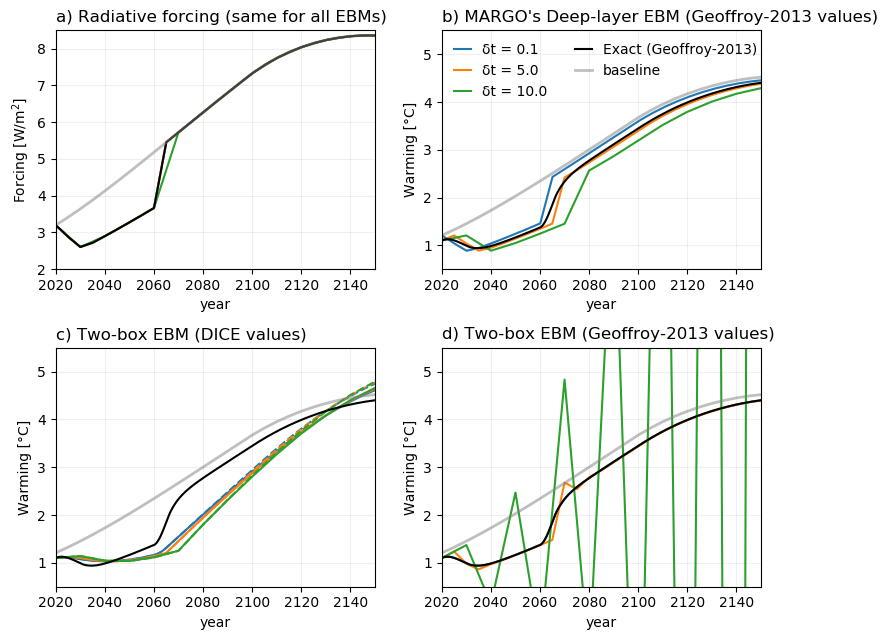

In [19]:
using Interpolations

## SRM_term
F_lo = F(only_SRM_term, M=true, R=true, G=true);
t_lo = t(only_SRM_term)

figure(figsize=(9, 6.5))

F2x0 = F2x(SRM_term)

colors = ["C0", "C1", "C2"]
for (i, Δt) = enumerate([0.1, 5.0, 10.])
    t_hi = 2020.:Δt:2200.

    itp = interpolate((t_lo,), F_lo, Gridded(Linear()))
    F_hi = itp(t_hi);
    subplot(2,2,1)
    plot(t_hi, F_hi.+3.)
    ylim(2., 8.5)
    xlim(2020, 2150)
    grid(true, alpha=0.2)
    xlabel("year")
    ylabel(L"Forcing [W/m$^{2}$]")
    title("a) Radiative forcing (same for all EBMs)", loc="left")

    subplot(2,2,2)
    T_hi = DICE_EBM(t_hi, Δt, F_hi, default="MARGO") .+ SRM_term.physics.T0;
    plot(t_hi, T_hi, label=string("δt = ",Δt))
    ylim(0.5, 5.5)
    xlim(2020, 2150)
    grid(true, alpha=0.2)
    xlabel("year")
    ylabel("Warming [°C]")
    title("b) MARGO's Deep-layer EBM (Geoffroy-2013 values)", loc="left")
    
    subplot(2,2,3)
    T_hi = DICE_EBM(t_hi, Δt, F_hi*3.8/F2x0, default="DICE-2013r") .+ SRM_term.physics.T0;
    plot(t_hi, T_hi,  "-", label="DICE-2013r", color=colors[i])
    T_hi = DICE_EBM(t_hi, Δt, F_hi*3.6813/F2x0, default="DICE-2016R") .+ SRM_term.physics.T0;
    plot(t_hi, T_hi,  "--", label="DICE-2016R", color=colors[i])
    ylim(0.5, 5.5)
    xlim(2020, 2150)
    grid(true, alpha=0.2)
    xlabel("year")
    ylabel("Warming [°C]")
    title("c) Two-box EBM (DICE values)", loc="left")
    
    subplot(2,2,4)
    T_hi = DICE_EBM(t_hi, Δt, F_hi, default="Geoffroy-2013") .+ SRM_term.physics.T0;
    plot(t_hi, T_hi, label=string("Δt = ",Δt))
    ylim(0.5, 5.5)
    xlim(2020, 2150)
    grid(true, alpha=0.2)
    xlabel("year")
    ylabel("Warming [°C]")
    title("d) Two-box EBM (Geoffroy-2013 values)", loc="left")
    
end

Δt = 0.01
t_hi = 2020.:Δt:2200.

itp = interpolate((t_lo,), F_lo, Gridded(Linear()))
F_hi = itp(t_hi);
subplot(2,2,1)
plot(t_hi, F_hi.+3., "k-")

for i = [2,3,4]
    subplot(2,2,i)
    T_hi = DICE_EBM(t_hi, Δt, F_hi, default="Geoffroy-2013") .+ SRM_term.physics.T0;
    plot(t_hi, T_hi, "k-", label="Exact (Geoffroy-2013)")
end

subplot(2,2,1)
plot(t(SRM), F(SRM).+3.0, "-", color="grey", lw=2, alpha=0.5)
for i = [2,3,4]
    subplot(2,2,i)
    plot(t(SRM), T(SRM), "k-", color="grey", lw=2, alpha=0.5, label="baseline")
end

subplot(2,2,2)
legend(loc="upper left", ncol=2, framealpha=0., handlelength=1.2)
tight_layout()
savefig("figures/EBM_SRM_compare.png", bbox_inches="tight", dpi=150.)